In [34]:
import os
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
llm_api_key=os.getenv("deepseekkey")
finance_key=os.getenv('financekey')
# print(llm_api_key,finance_key)


In [35]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import requests
import numpy as np

URL="https://www.alphavantage.co/query"

@tool
def stockprice(stock_name:str)->float:
    """ returns the stock price for the given stock name for the day """
    params = {
    "function": "TIME_SERIES_INTRADAY",
    "symbol": stock_name,
    "apikey": finance_key  # Replace with your actual API key
    }
    response = requests.get(URL, params=params)
    data = response.json()
    for  i in data['Time Series (Daily)']:
        mean=abs(np.mean([float(data['Time Series (Daily)'][i]['1. open']),float(data['Time Series (Daily)'][i]['4. close'])]))
        break
    # print(mean)
    return mean

@tool
def stockdetail(stock_name:str)->str:
    '''returns information of the given stock name'''
    params={
        "function":"OVERVIEW",
        "symbol":stock_name,
        "apikey":finance_key
    }
    response = requests.get(URL, params=params)
    data = response.json()
    # print(f"discription: {data['Description']}\nsector: {data['Sector']}")
    return f"discription: {data['Description']}\nsector: {data['Sector']}"

tools=[stockdetail,stockprice]
toolnode=ToolNode(tools=tools)

In [36]:
from langchain_openai import ChatOpenAI
model= ChatOpenAI(model="deepseek/deepseek-chat-v3-0324:free",api_key=llm_api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools=tools)

In [51]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage], add_messages]


def decision1(state:Agent):
    # a=input("should continue")
    a="yes"
    if a=="no":
        return "end"
    else:
        return "continue"

def decision2(state:Agent):
    if getattr(state['message'][-1],'tool_calls'):
        return 'tools'
    return "print"

def llm_node(state: Agent)->Agent:
    # inp=input("enter the message")
    inp="apple stock price" #temp
    systemprompt=[SystemMessage(content=f"""
    You are a finance assistent that helps answers the user's queries.you have a set of tools which are
    stockprice: use this tool get price of a stock the input requires precise stock name.
    stockdetail: use this tool to get infromation of the company of the stock the input requires precise stock name.                             
    """),
    HumanMessage(content=inp)]
    # response = model.invoke(systemprompt)
    ai_msg = AIMessage(
        content='',
        additional_kwargs={
            'tool_calls': [
                {
                    'id': 'call_6040035298494ff0bf54f2f3',
                    'function': {
                        'arguments': '{"stock_name": "apple"}',
                        'name': 'stockprice'
                    },
                    'type': 'function',
                    'index': 0
                }
            ],
            'refusal': None
        },
        id='run--b8024da6-4f17-4f22-9557-e147a8d0fa08-0',
        tool_calls=[
            {
                'name': 'stockprice',
                'args': {'stock_name': 'apple'},
                'id': 'call_6040035298494ff0bf54f2f3',
                'type': 'tool_call'
            }
        ]
    )

    return {"message": state['message']+[ai_msg]}

def preetyprint(state:Agent)->Agent:
    print(state['message'])
    return{'message':[]}

In [ ]:
graph=StateGraph(Agent)
graph.add_node('dec1',lambda state:state)
graph.add_node('dec2',lambda state:state)
graph.add_node('llm',llm_node)
graph.add_node('tools',toolnode)
graph.add_node('print',preetyprint)
graph.set_entry_point('dec1')
graph.add_conditional_edges('dec1',
                            decision1,
                            {
                                "continue":"llm",
                                "end": END,
                            }
                            )
graph.add_edge('llm','dec2')
graph.add_conditional_edges('dec2',
                            decision2,
                            {
                                "tools":"tools",
                                "print":"print",
                            }
                            )
graph.add_edge('tools','print')
graph.add_edge('print','dec1')
app=graph.compile()

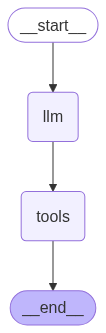

In [54]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [53]:
graph=StateGraph(Agent)
graph.add_node('llm',llm_node)
graph.add_node('tools',toolnode)
graph.set_entry_point('llm')
graph.add_edge('llm','tools')
graph.add_edge('tools',END)
app=graph.compile()

In [55]:
res=app.invoke({'message':[]})
print('f =',res)

ValueError: No message found in input

In [ ]:
f = {'message': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6040035298494ff0bf54f2f3', 'function': {'arguments': '{"stock_name": "apple"}', 'name': 'stockprice'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 400, 'total_tokens': 424, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen/qwen3-coder:free', 'system_fingerprint': None, 'id': 'gen-1755153745-DgQYk0IOlSk48yCN0SUp', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b8024da6-4f17-4f22-9557-e147a8d0fa08-0', tool_calls=[{'name': 'stockprice', 'args': {'stock_name': 'apple'}, 'id': 'call_6040035298494ff0bf54f2f3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 400, 'output_tokens': 24, 'total_tokens': 424, 'input_token_details': {}, 'output_token_details': {}})]}

In [46]:
f['message'][0].tool_calls

[{'name': 'stockprice',
  'args': {'stock_name': 'apple'},
  'id': 'call_6040035298494ff0bf54f2f3',
  'type': 'tool_call'}]

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState
from langchain_core.tools import tool
import requests, numpy as np

finance_key = "YOUR_KEY"
URL = "https://www.alphavantage.co/query"

@tool
def stockprice(stock_name: str) -> float:
    """Returns the stock price for the given stock name for the day."""
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": stock_name,
        "apikey": finance_key
    }
    try:
        response = requests.get(URL, params=params)
        data = response.json()
        for i in data['Time Series (Daily)']:
            mean = abs(np.mean([
                float(data['Time Series (Daily)'][i]['1. open']),
                float(data['Time Series (Daily)'][i]['4. close'])
            ]))
            break
        return mean
    except Exception as e:
@tool
def stockdetail(stock_name: str) -> str:
    """Returns information of the given stock name."""
    params = {
        "function": "OVERVIEW",
        "symbol": stock_name,
        "apikey": finance_key
    }
    response = requests.get(URL, params=params)
    data = response.json()
    return f"description: {data.get('Description', '')}\nsector: {data.get('Sector', '')}"

tools = [stockdetail, stockprice]

def llm_node(state: MessagesState) -> MessagesState:
    # Normally you call your model here; I’m hardcoding the output
    ai_msg = AIMessage(
        content='',
        tool_calls=[{
            'name': 'stockprice',
            'args': {'stock_name': 'AAPL'},  # <-- Must match your tool arg name
            'id': 'call_123',
            'type': 'tool_call'
        }]
    )
    return {"messages": state["messages"] + [ai_msg]}

toolnode = ToolNode(tools=tools)

# Build graph
graph = StateGraph(MessagesState)
graph.add_node("llm", llm_node)
graph.add_node("tools", toolnode)

graph.add_edge("llm", "tools")
graph.set_entry_point("llm")

app = graph.compile()

# Run
res = app.invoke({"messages": [HumanMessage(content="apple stock price")]})
print(res)


{'messages': [HumanMessage(content='apple stock price', additional_kwargs={}, response_metadata={}, id='28b9b87e-99bd-445a-af16-6308c0dd9294'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='b40f05a7-ea23-4968-83c0-34daf6ca348f', tool_calls=[{'name': 'stockprice', 'args': {'stock_name': 'AAPL'}, 'id': 'call_123', 'type': 'tool_call'}]), ToolMessage(content='232.2', name='stockprice', id='ed32c385-b79b-45d4-b887-e08689c318f6', tool_call_id='call_123')]}


In [61]:
params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": 'IBM',
        "apikey": finance_key
    }
response = requests.get(URL, params=params)
data = response.json()
print(data)
for i in data['Time Series (Daily)']:
    mean = abs(np.mean([
        float(data['Time Series (Daily)'][i]['1. open']),
        float(data['Time Series (Daily)'][i]['4. close'])
    ]))
    break
print(mean)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2025-08-13', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-08-13': {'1. open': '236.2000', '2. high': '240.8411', '3. low': '236.2000', '4. close': '240.0700', '5. volume': '5663562'}, '2025-08-12': {'1. open': '236.5300', '2. high': '237.9600', '3. low': '233.3600', '4. close': '234.7700', '5. volume': '8800597'}, '2025-08-11': {'1. open': '242.2400', '2. high': '243.1500', '3. low': '234.7000', '4. close': '236.3000', '5. volume': '9381960'}, '2025-08-08': {'1. open': '248.8800', '2. high': '249.4800', '3. low': '241.6500', '4. close': '242.2700', '5. volume': '6828390'}, '2025-08-07': {'1. open': '252.8100', '2. high': '255.0000', '3. low': '248.8750', '4. close': '250.1600', '5. volume': '6251285'}, '2025-08-06': {'1. open': '251.5300', '2. high': '254.3200', '3. low': '249.2800', '4. close': '252.2800', '5. volu